# Demo Similarity

**Base Model**

* era5

**CMIP5 Models**:
* "inmcm4",
* "access1_0",
* "bcc_csm1_1",
* "bcc_csm1_1_m",
* "bnu_esm",
* "cnrm_cm5",
* "ec_earth",
* "fgoals_s2",
* "ipsl_cm5b_lr",
* "mpi_esm_lr",
* "mpi_esm_mr"

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
isp_root = "/home/emmanuel/code/isp_data"
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))
sys.path.append(str(isp_root))

from pathlib import Path

#
import xarray as xr
from pprint import pprint
import cftime
import xesmf as xe
from isp_data.esdc.temporal import convert_to_360day_monthly
from src.models.univariate import pearson
from src.models.kernels import rv_coefficient, cka_coefficient
import tqdm
import numpy as np
import pandas as pd
import itertools

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
ERA5_DIR = "/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/ERA5/REANALYSIS/ZARR"
CMIP5_DIR = "/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF"
VARIABLE = "mean_sea_level_pressure"
TIME_SLICE = slice("2020", "2020")
BASE_GRID_MODEL = "ipsl_cm5b_lr"


In [3]:
d_ = xr.open_zarr("/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/ERA5/REANALYSIS/ZARR/mean_sea_level_pressure/era5_reanalysis.nc")

In [4]:
!ls $ERA5_DIR

mean_sea_level_pressure


In [5]:

cmip_glob = Path(CMIP5_DIR).joinpath(VARIABLE).glob(f"*.nc")
era5_glob = Path(ERA5_DIR).joinpath(VARIABLE).glob(f"*.nc")
nc_files = [str(x) for x in cmip_glob if x.is_dir()]
nc_files = nc_files + [str(x) for x in era5_glob if x.is_dir()]

In [6]:
nc_files

['/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/giss_e2_h_cc_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/mpi_esm_lr_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/bnu_esm_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/access1_0_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/access1_3_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/noresm1_m_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/mpi_esm_mr_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/

In [7]:
ds = {}
for ifile in nc_files:
    # manually set the encoding to use cftime

    i_ds = xr.open_zarr(ifile, decode_times=True, use_cftime=True)

    # assign a new coordinate name
    try:
        model_id = i_ds.model_id.lower().replace("-", "_")

    except:
        model_id = "era5"
        i_ds = i_ds.rename({"msl": "psl", "latitude": "lat", "longitude": "lon"})
    i_ds = i_ds.assign_coords({"model_id": model_id})
    # create the same calendar
    i_ds = convert_to_360day_monthly(i_ds, False)

    # move attributes to new coordinate
    i_ds.model_id.attrs = i_ds.attrs
    i_ds.attrs = {}

    ds[model_id] = i_ds

In [8]:
# =====================
# Select Time Slice
# =====================
with tqdm.tqdm(ds.items()) as pbar:
    for imodel_id, ids in pbar:
        
        pbar.set_description(f"Model: {model_id}")

        ds[imodel_id] = ds[imodel_id].sel(time=TIME_SLICE)

n_time = ds[imodel_id]["time"].values.shape[0]

Model: era5: 100%|██████████| 13/13 [00:00<00:00, 219.48it/s]


In [9]:
# =====================
# REGRID
# =====================
ds_out = xr.Dataset(
    {
        "lat": (["lat"], ds[BASE_GRID_MODEL].lat),
        "lon": (["lon"], ds[BASE_GRID_MODEL].lon),
    }
)

n_lat = ds_out.coords["lat"].values.shape[0]
n_lon = ds_out.coords["lon"].values.shape[0]

final_ds = []

for imodel_id, ids in ds.items():
#     if imodel_id == "ipsl_cm5b_lr":
#         t = ids.psl
#         t.attrs = ids.attrs
#         final_ds.append(t)
#         continue

    regridder = xe.Regridder(ids, ds_out, "nearest_s2d")
    t = regridder(ids["psl"].compute())
    t.attrs = ids.attrs
    final_ds.append(t)

final_ds = xr.concat(final_ds, dim="model_id").reset_coords()

/home/emmanuel/.conda/envs/rbig4eo/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [10]:
final_ds.coords["model_id"].values

array(['giss_e2_h_cc', 'mpi_esm_lr', 'bnu_esm', 'access1_0', 'access1_3',
       'noresm1_m', 'mpi_esm_mr', 'ipsl_cm5b_lr', 'ipsl_cm5a_mr',
       'inmcm4', 'fio_esm', 'ipsl_cm5a_lr', 'era5'], dtype='<U12')

In [11]:
from src.models.km.hsic import cka_coefficient
from src.models.km.rv import rv_coefficient
from src.models.km.rhsic import cka_coefficient_nystroem, cka_coefficient_rff
from src.models.univariate import pearson, pearson_dim, univariate_stats
from src.models.multivariate import multivariate_stats
import itertools

In [84]:
knn_entropy(np.hstack([X, Y]), 5, n_jobs=-1)

/home/emmanuel/projects/rbig4eo/src/models/information/knn.py:28: RuntimeWarning: divide by zero encountered in true_divide
  + np.log(vol)


-inf

In [85]:
np.hstack([X, Y]).shape, np.vstack([X, Y]).shape

((9216, 24), (18432, 12))

In [45]:
X_ = np.ones((100, 10))
X_.ravel()[:, None].shape

(1000, 1)

In [59]:
x.shape

(9216, 12)

In [62]:
import sklearn
sklearn.show_versions()


System:
    python: 3.8.8 (default, Feb 24 2021, 21:46:12)  [GCC 7.3.0]
executable: /home/emmanuel/.conda/envs/rbig4eo/bin/python
   machine: Linux-3.10.0-1127.el7.x86_64-x86_64-with-glibc2.10

Python dependencies:
          pip: 21.0.1
   setuptools: 52.0.0.post20210125
      sklearn: 0.24.1
        numpy: 1.19.2
        scipy: 1.6.2
       Cython: None
       pandas: 1.2.3
   matplotlib: 3.3.4
       joblib: 1.0.1
threadpoolctl: 2.1.0

Built with OpenMP: True


In [65]:
mi

0.5468217400020379

In [80]:
knn_entropy(np.vstack([X, Y]), 2, n_jobs=-1)

63.553461176557825

In [81]:
x.shape, y.shape

((9216, 12), (9216, 12))

In [12]:
from src.models.information.mutual_information import RBIGEstimator

In [12]:
# spyder up to find the root
rbig_root = "/home/emmanuel/code/rbig_jax"

# append to path
sys.path.append(str(rbig_root))

In [13]:
from rbig_jax.information.mi import rbig_mutual_info, rbig_mutual_info_sum

In [69]:
# =====================
# PEARSON CORRELATION
# =====================

import pandas as pd


from scipy.stats import pearsonr
from sklearn.feature_selection._mutual_info import _compute_mi as knn_mi

# get all model IDS
EXPERIMENT = "multivariate"

import tqdm
import numpy as np
import time


all_stats = pd.DataFrame()
model_ids = final_ds.coords["model_id"].values
sym_pairs = [pair for pair in itertools.combinations(model_ids, 2)]

with tqdm.tqdm(sym_pairs) as pbar:

    for i, imodel_pair in enumerate(pbar):
        
        imodel_stats = {"model_0": imodel_pair[0], "model_1": imodel_pair[1]}

        pbar.set_description(f"Model 1: {imodel_pair[0]}, Model 2: {imodel_pair[1]}")

        # select model
        ids = final_ds.sel(model_id=[imodel_pair[0], imodel_pair[1]]).psl.values


        # calculate pearson correlation
#         pbar.set_description(f"Calculating Correlation...")
        
#         x = np.reshape(ids[0], (n_lat * n_lon * n_time))
#         y = np.reshape(ids[1], (n_lat * n_lon * n_time))
        
        if EXPERIMENT == "univariate":

            # calculate pearson correlation
            pbar.set_description(f"Calculating Univariate Stats...")

            x = np.reshape(ids[0], (n_lat * n_lon * n_time))
            y = np.reshape(ids[1], (n_lat * n_lon * n_time))

            uni_stats = univariate_stats(x, y)
            
            imodel_stats = {**imodel_stats, **uni_stats}
            
        elif EXPERIMENT == "multivariate":

            # calculate pearson correlation
            pbar.set_description(f"Calculating Multivariate Stats...")

            x = np.reshape(ids[0], (n_lat * n_lon, n_time))
            y = np.reshape(ids[1], (n_lat * n_lon, n_time))

#             multi_stats = multivariate_stats(x, y)
            
#             imodel_stats = {**imodel_stats, **multi_stats}
            
#             # calculate pearson correlation
#             pbar.set_description(f"Calculating Info Stats (RBIG)...")
            
#             t0 = time.time()
#             mi_XY_rbig = rbig_mutual_info(
#                 X=jnp.array(x, jnp.float32).block_until_ready(),
#                 Y=jnp.array(y, jnp.float32).block_until_ready(),
#                 zero_tolerance=30,
#             )
            
#             imodel_stats["mi_X"] = np.array(mi_XY_rbig.mi_X)
#             imodel_stats["mi_Y"] = np.array(mi_XY_rbig.mi_Y)
#             imodel_stats["mi_XY"] = np.array(mi_XY_rbig.mi_XY)
#             imodel_stats["mi_time"] = time.time() - t0
            
            pbar.set_description(f"Calculating Info Stats (KNN)...")
            t0 = time.time()
            mi = knn_mi(x, y, None, None, 3)
            
            imodel_stats["mi_xy_knn"] = mi
            imodel_stats["mi_time"] = time.time() - t0
            
#         prs_r = pearson(x, y)
        
#         imodel_stats = {**imodel_stats, **prs_r}
        
        
#         X = np.reshape(ids[0], (n_lat * n_lon, n_time))
#         Y = np.reshape(ids[1], (n_lat * n_lon, n_time))
        
#         # calculate pearson correlation
#         pbar.set_description(f"Calculating Pearson (per dim)...")

#         prs_d_r = pearson_dim(X, Y)
        
#         imodel_stats = {**imodel_stats, **prs_d_r}
        
#         # calculate pearson correlation
#         pbar.set_description(f"Calculating RV Coeff ...")
        
#         X = np.reshape(ids[0], (n_lat * n_lon, n_time))
#         Y = np.reshape(ids[1], (n_lat * n_lon, n_time))
#         rv = rv_coefficient(X, Y)
        
#         imodel_stats = {**imodel_stats, **rv}
        
        
#         # calculate pearson correlation
#         pbar.set_description(f"Calculating nHSIC Coeff...")
        
#         nhsic = cka_coefficient(X, Y)
        
#         imodel_stats = {**imodel_stats, **nhsic}
                
#         # calculate cka (nystrom)
#         pbar.set_description(f"Calculating rand nHSIC (nystroem) Coeff...")
        
#         rhsic_nys = cka_coefficient_nystroem(X, Y, )
        
#         imodel_stats = {**imodel_stats, **rhsic_nys}
        
#         # calculate cka (rff)
#         pbar.set_description(f"Calculating rand nHSIC (rff) Coeff...")
        
#         rhsic_rff = cka_coefficient_rff(X, Y)
        
#         imodel_stats = {**imodel_stats, **rhsic_rff}
        
        
        all_stats = pd.concat([all_stats, pd.DataFrame(imodel_stats, index=[i])], axis=0)

Calculating Info Stats (KNN)...: 100%|██████████| 78/78 [01:07<00:00,  1.15it/s]             


In [ ]:
%%time
mi_clf = RBIGEstimator().fit(x, y)

In [17]:
%%time

import jax.numpy as jnp




CPU times: user 1min 2s, sys: 2min 48s, total: 3min 51s
Wall time: 21.9 s


In [18]:
mi_XY_rbig

RBIGMutualInfo(mi_X=DeviceArray(23.906412, dtype=float32), mi_Y=DeviceArray(26.896477, dtype=float32), mi_XY=DeviceArray(0.87111145, dtype=float32))

In [39]:
all_stats

,model_0,model_1,pearson_d,pearson_dtime,x_std_d,y_std_d,rv_coeff,rv_xy_norm,rv_x_norm,rv_y_norm,...,rcka_nys_time,rcka_coeff_rff,rcka_xy_norm_rff,rcka_x_norm_rff,rcka_y_norm_rff,rcka_time_rff,mi_X,mi_Y,mi_XY,mi_time
0,giss_e2_h_cc,mpi_esm_lr,0.797626,0.010077,981.968832,966.831601,0.664706,7.746479e+13,1.096883e+07,1.062465e+07,...,0.357419,0.428817,0.030157,0.248835,0.282618,0.425420,23.906412,26.896477,0.871111,18.656734
1,giss_e2_h_cc,bnu_esm,0.690945,0.021986,981.968832,1241.150521,0.494379,9.703133e+13,1.096883e+07,1.789334e+07,...,0.437461,0.332026,0.025050,0.272314,0.277056,0.456047,23.906412,36.144955,0.642459,20.760954
2,giss_e2_h_cc,access1_0,0.817646,0.018168,981.968832,1169.138350,0.698992,1.216271e+14,1.096883e+07,1.586346e+07,...,0.344050,0.444333,0.032576,0.255619,0.286815,0.411298,23.906412,30.668901,0.809352,19.782911
3,giss_e2_h_cc,access1_3,0.826803,0.006708,981.968832,1223.082688,0.718017,1.370419e+14,1.096883e+07,1.740036e+07,...,0.356247,0.548097,0.040247,0.264373,0.277756,0.424659,23.906412,31.153751,0.827287,21.021130
4,giss_e2_h_cc,noresm1_m,0.740417,0.007929,981.968832,1180.197104,0.572803,1.013367e+14,1.096883e+07,1.612875e+07,...,0.423548,0.355934,0.025643,0.256217,0.281182,0.459287,23.906412,29.564209,0.729491,20.623222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,inmcm4,ipsl_cm5a_lr,0.613359,0.007497,1066.321300,1395.716204,0.375564,1.040995e+14,1.285414e+07,2.156363e+07,...,0.361017,0.304300,0.017669,0.244409,0.237570,0.413494,29.469099,27.477760,0.751548,21.304297
74,inmcm4,era5,0.830532,0.022857,1066.321300,1122.861659,0.711749,1.328509e+14,1.285414e+07,1.452092e+07,...,0.357482,0.455990,0.034069,0.276439,0.270274,0.413487,29.469099,26.657843,0.863049,22.634000
75,fio_esm,ipsl_cm5a_lr,0.304418,0.008103,1272.579721,1395.716204,0.090399,3.679829e+13,1.887730e+07,2.156363e+07,...,0.364390,0.401301,0.032566,0.290229,0.279610,0.410810,35.797546,27.477760,0.644754,19.951184
76,fio_esm,era5,0.830279,0.006405,1272.579721,1122.861659,0.713211,1.955023e+14,1.887730e+07,1.452092e+07,...,0.362784,0.454276,0.033056,0.264475,0.275131,0.405536,35.797546,26.657843,0.804638,21.856426


In [24]:
from src.visualization.climate.utils import get_pivot_df

In [26]:
df_ = get_pivot_df(all_stats, "pearson_d")
df_

model_1,access1_0,access1_3,bnu_esm,era5,fio_esm,giss_e2_h_cc,inmcm4,ipsl_cm5a_lr,ipsl_cm5a_mr,ipsl_cm5b_lr,mpi_esm_lr,mpi_esm_mr,noresm1_m
model_0,,,,,,,,,,,,,
access1_0,NaN,0.915365,0.756036,0.816048,0.831421,0.817646,0.660696,0.175718,0.256822,0.166424,0.786444,0.757292,0.850116
access1_3,0.915365,NaN,0.770625,0.848669,0.851863,0.826803,0.709470,0.172802,0.264249,0.161856,0.784127,0.732413,0.860206
bnu_esm,0.756036,0.770625,NaN,0.790381,0.813721,0.690945,0.713483,0.277418,0.354031,0.288214,0.707306,0.762579,0.837644
era5,0.816048,0.848669,0.790381,NaN,0.830279,0.787481,0.830532,0.380557,0.503758,0.379739,0.793355,0.751341,0.859617
fio_esm,0.831421,0.851863,0.813721,0.830279,NaN,0.780078,0.720738,0.304418,0.380840,0.252689,0.741102,0.813644,0.856236
giss_e2_h_cc,0.817646,0.826803,0.690945,0.787481,0.780078,NaN,0.729390,0.364771,0.429811,0.370837,0.797626,0.713163,0.740417
inmcm4,0.660696,0.709470,0.713483,0.830532,0.720738,0.729390,NaN,0.613359,0.696811,0.593903,0.763374,0.672916,0.743868
ipsl_cm5a_lr,0.175718,0.172802,0.277418,0.380557,0.304418,0.364771,0.613359,NaN,0.860319,0.892734,0.457580,0.345519,0.259692
ipsl_cm5a_mr,0.256822,0.264249,0.354031,0.503758,0.380840,0.429811,0.696811,0.860319,NaN,0.857685,0.478454,0.404187,0.361470


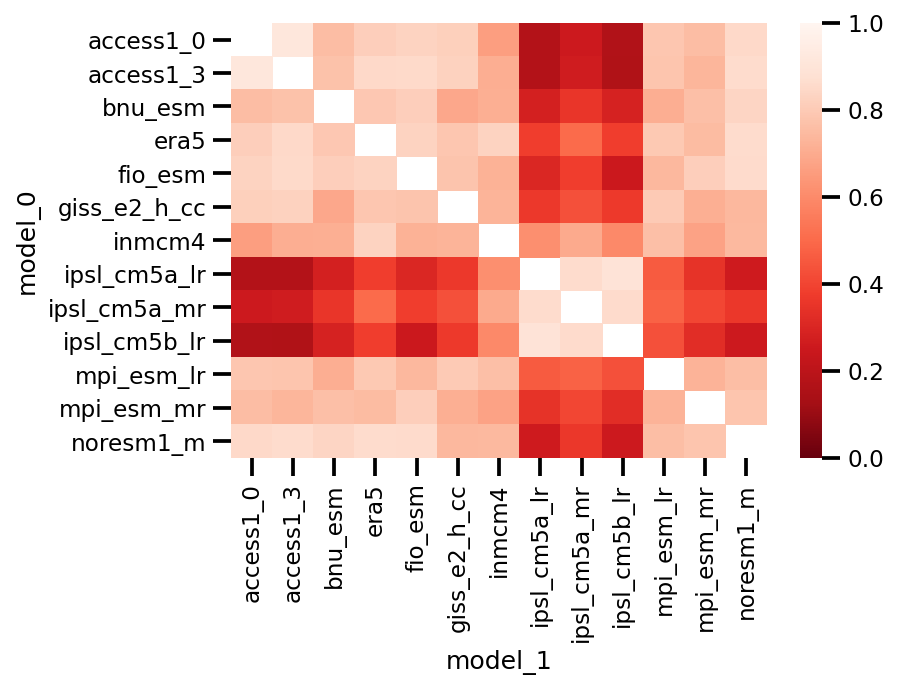

In [50]:
t = all_stats[["model_0", "model_1", "pearson_d"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "pearson_d")

ax = sns.heatmap(df_, vmin=0, vmax=1.0, cmap='Reds_r')

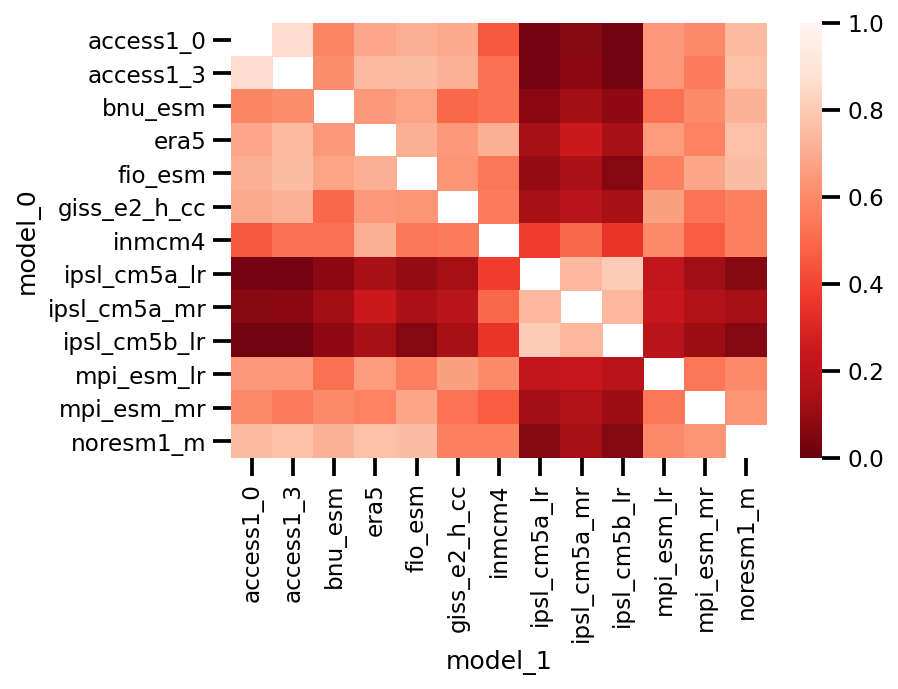

In [48]:
t = all_stats[["model_0", "model_1", "rv_coeff"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "rv_coeff")

ax = sns.heatmap(t, vmin=0, vmax=1.0, cmap='Reds_r')

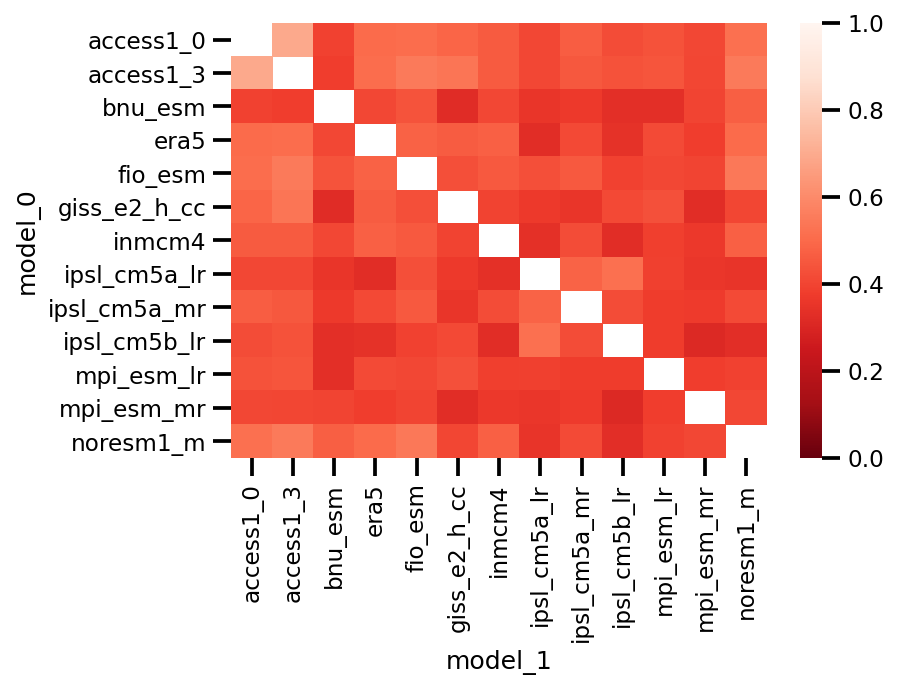

In [46]:
t = all_stats[["model_0", "model_1", "cka_coeff"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "cka_coeff")

ax = sns.heatmap(t, vmin=0, vmax=1.0, cmap='Reds_r')

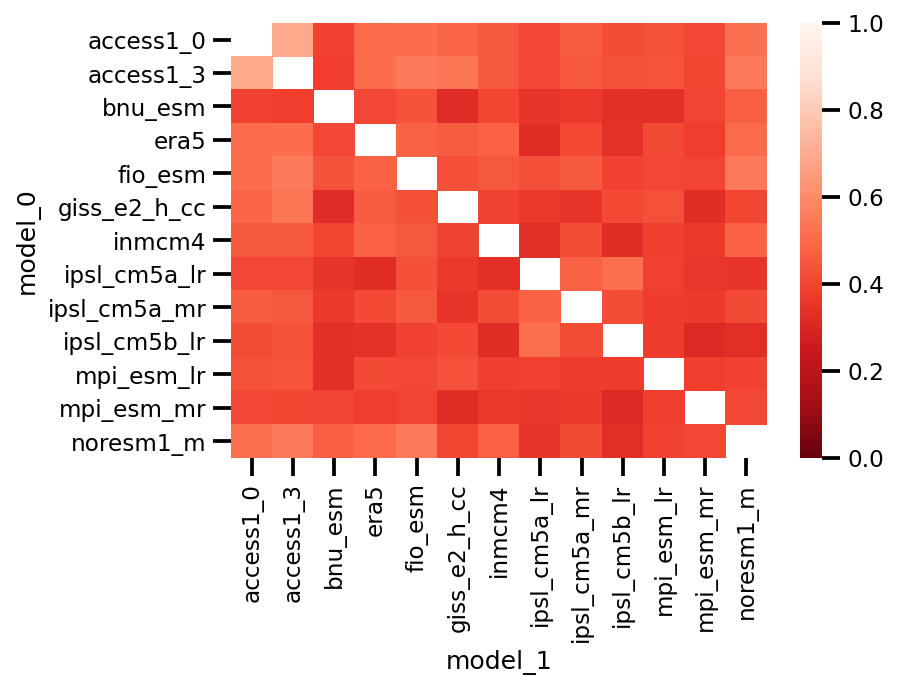

In [45]:
t = all_stats[["model_0", "model_1", "rcka_coeff_nys"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "rcka_coeff_nys")

ax = sns.heatmap(t, vmin=0, vmax=1.0, cmap='Reds_r')

In [37]:
all_stats.head()

,model_0,model_1,pearson_d,pearson_dtime,x_std_d,y_std_d,rv_coeff,rv_xy_norm,rv_x_norm,rv_y_norm,...,rcka_nys_time,rcka_coeff_rff,rcka_xy_norm_rff,rcka_x_norm_rff,rcka_y_norm_rff,rcka_time_rff,mi_X,mi_Y,mi_XY,mi_time
0,giss_e2_h_cc,mpi_esm_lr,0.797626,0.010077,981.968832,966.831601,0.664706,7.746479e+13,1.096883e+07,1.062465e+07,...,0.357419,0.428817,0.030157,0.248835,0.282618,0.425420,23.906412,26.896477,0.871111,18.656734
1,giss_e2_h_cc,bnu_esm,0.690945,0.021986,981.968832,1241.150521,0.494379,9.703133e+13,1.096883e+07,1.789334e+07,...,0.437461,0.332026,0.025050,0.272314,0.277056,0.456047,23.906412,36.144955,0.642459,20.760954
2,giss_e2_h_cc,access1_0,0.817646,0.018168,981.968832,1169.138350,0.698992,1.216271e+14,1.096883e+07,1.586346e+07,...,0.344050,0.444333,0.032576,0.255619,0.286815,0.411298,23.906412,30.668901,0.809352,19.782911
3,giss_e2_h_cc,access1_3,0.826803,0.006708,981.968832,1223.082688,0.718017,1.370419e+14,1.096883e+07,1.740036e+07,...,0.356247,0.548097,0.040247,0.264373,0.277756,0.424659,23.906412,31.153751,0.827287,21.021130
4,giss_e2_h_cc,noresm1_m,0.740417,0.007929,981.968832,1180.197104,0.572803,1.013367e+14,1.096883e+07,1.612875e+07,...,0.423548,0.355934,0.025643,0.256217,0.281182,0.459287,23.906412,29.564209,0.729491,20.623222


In [42]:
all_stats[["model_0", "model_1"]]

,model_0,model_1
0,giss_e2_h_cc,mpi_esm_lr
1,giss_e2_h_cc,bnu_esm
2,giss_e2_h_cc,access1_0
3,giss_e2_h_cc,access1_3
4,giss_e2_h_cc,noresm1_m
...,...,...
73,inmcm4,ipsl_cm5a_lr
74,inmcm4,era5
75,fio_esm,ipsl_cm5a_lr
76,fio_esm,era5


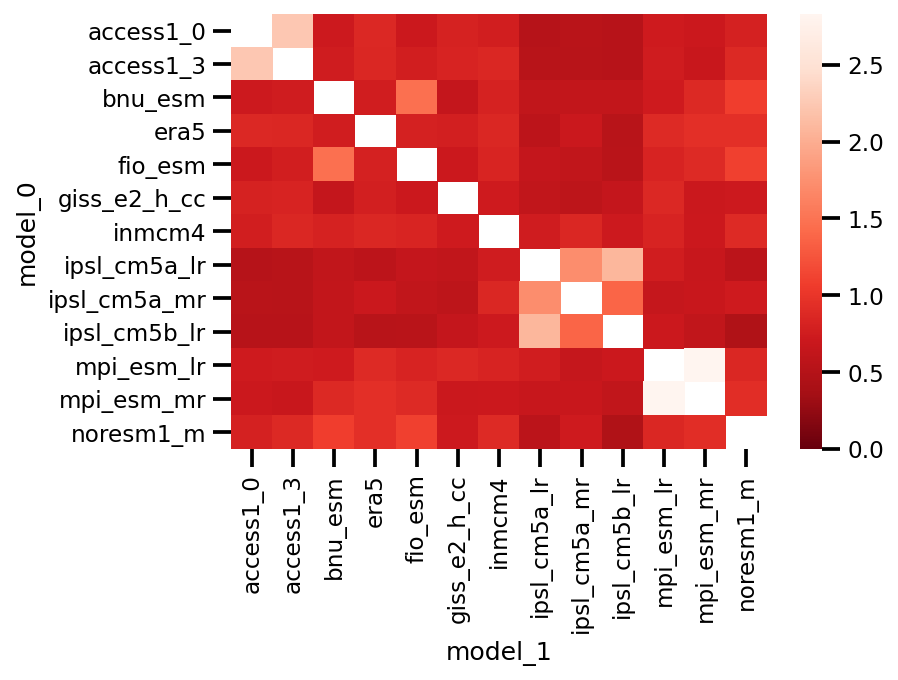

In [52]:
t = all_stats.rename(columns={"mi_XY": "mi_xy"})
t = t[["model_0", "model_1", "mi_xy"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "mi_xy")
# df_ = get_pivot_df(all_stats, "pearson")

ax = sns.heatmap(t, vmin=0.0, cmap='Reds_r')

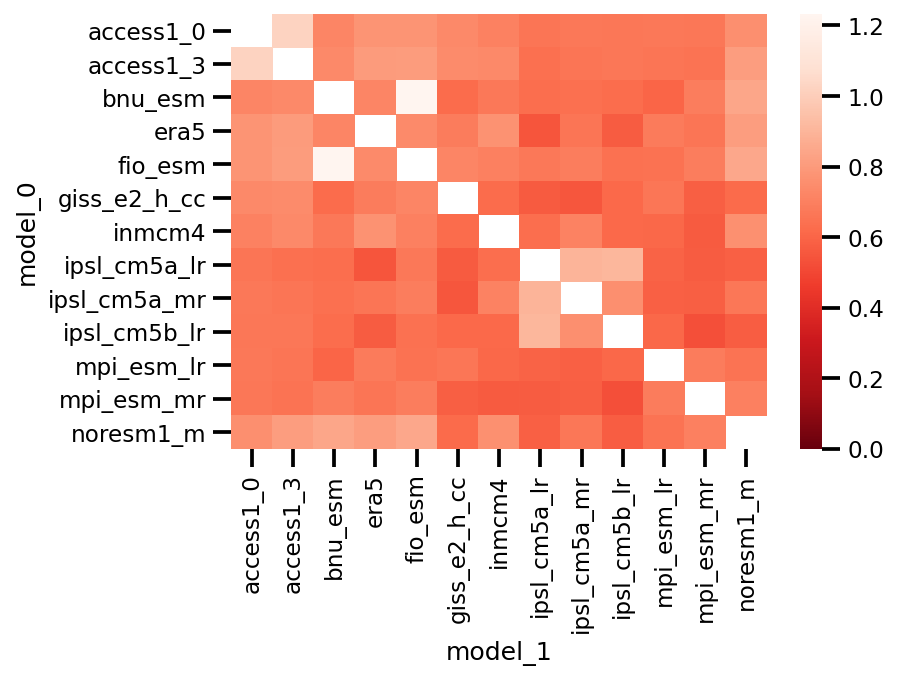

In [74]:
t = all_stats[["model_0", "model_1", "mi_xy_knn"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "mi_xy_knn")
# df_ = get_pivot_df(all_stats, "pearson")

ax = sns.heatmap(t, vmin=0.0, cmap='Reds_r')

In [88]:
import scipy.cluster.hierarchy as spc
pdist = max(t.max().max(), 1) - np.abs(t.values)
pdist = pdist[np.triu_indices_from(pdist, k=1)]
linkage = spc.linkage(pdist, method="complete", optimal_ordering=True)
order = spc.leaves_list(linkage)

name_corrections = {
    "access1_0": "ACCESS-1.0",
    "access1_3": "ACCESS-3.0",
    "bnu_esm": "BNU-ESM",
    "era5": "ERA5",
    "inmcm4": "INMCM4",
    "ipsl_cm5a_lr": "IPSL-CM5A-LR",
    "ipsl_cm5b_lr": "IPSL-CM5B-LR",
    "ipsl_cm5a_mr": "IPSL-CM5A-MR",
    "mpi_esm_lr": "MPI-ESM-LR",
    "mpi_esm_mr": "MPI-ESM-MR",
    "giss_e2_h_cc": "GISS-E2-H-CC",
    "fio_esm": "FIO-ESM",
    "noresm1_m": "NORESM1-M",
    "ccsm4": "CCSM4",
}
names = [i for i in name_corrections.values()]
# def names(i):
#     return name_corrections

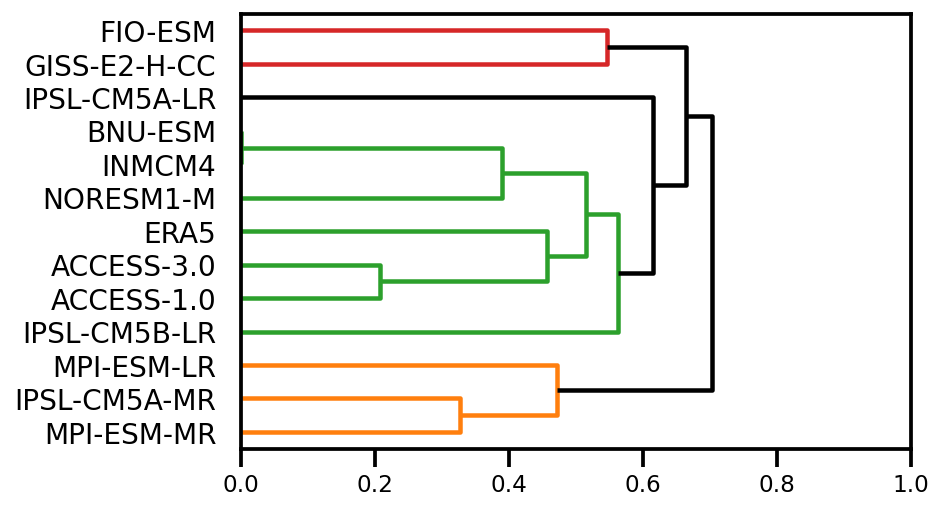

In [91]:
fig, ax = plt.subplots()
d = spc.dendrogram(
        linkage,
        above_threshold_color="k",
        color_threshold=0.6,
        orientation="right",
        leaf_label_func=lambda i: names[i],
        leaf_font_size=14,
        leaf_rotation=0,
    ax=ax
    )
ax.set_xlim([0.0, 1.0])
plt.show()

In [ ]:
all_pairs = [pair for pair in itertools.product(model_ids, model_ids)]

grid_size =

for im, jm in all_pairs

In [ ]:
from src.models.univariate import univariate_stats, pearson
from src.models.kernels import rv_coefficient, cka_coefficient

In [47]:
model_ids

array(['inmcm4', 'bnu_esm', 'ipsl_cm5b_lr', 'mpi_esm_mr', 'access1_0',
       'mpi_esm_lr', 'era5'], dtype='<U12')

In [61]:
[pair for pair in itertools.product(model_ids, model_ids)]

[('giss_e2_h_cc', 'giss_e2_h_cc'),
 ('giss_e2_h_cc', 'mpi_esm_lr'),
 ('giss_e2_h_cc', 'bnu_esm'),
 ('giss_e2_h_cc', 'access1_0'),
 ('giss_e2_h_cc', 'access1_3'),
 ('giss_e2_h_cc', 'noresm1_m'),
 ('giss_e2_h_cc', 'mpi_esm_mr'),
 ('giss_e2_h_cc', 'ipsl_cm5b_lr'),
 ('giss_e2_h_cc', 'ccsm4'),
 ('giss_e2_h_cc', 'ipsl_cm5a_mr'),
 ('giss_e2_h_cc', 'inmcm4'),
 ('giss_e2_h_cc', 'fio_esm'),
 ('giss_e2_h_cc', 'ipsl_cm5a_lr'),
 ('giss_e2_h_cc', 'era5'),
 ('mpi_esm_lr', 'giss_e2_h_cc'),
 ('mpi_esm_lr', 'mpi_esm_lr'),
 ('mpi_esm_lr', 'bnu_esm'),
 ('mpi_esm_lr', 'access1_0'),
 ('mpi_esm_lr', 'access1_3'),
 ('mpi_esm_lr', 'noresm1_m'),
 ('mpi_esm_lr', 'mpi_esm_mr'),
 ('mpi_esm_lr', 'ipsl_cm5b_lr'),
 ('mpi_esm_lr', 'ccsm4'),
 ('mpi_esm_lr', 'ipsl_cm5a_mr'),
 ('mpi_esm_lr', 'inmcm4'),
 ('mpi_esm_lr', 'fio_esm'),
 ('mpi_esm_lr', 'ipsl_cm5a_lr'),
 ('mpi_esm_lr', 'era5'),
 ('bnu_esm', 'giss_e2_h_cc'),
 ('bnu_esm', 'mpi_esm_lr'),
 ('bnu_esm', 'bnu_esm'),
 ('bnu_esm', 'access1_0'),
 ('bnu_esm', 'access1_3'),

In [90]:
import itertools
all_pairs = [pair for pair in itertools.product(model_ids, model_ids)]
inv_pairs = map(lambda x: tuple(reversed(x)), all_pairs)

all_pairs

[('inmcm4', 'inmcm4'),
 ('inmcm4', 'bnu_esm'),
 ('inmcm4', 'ipsl_cm5b_lr'),
 ('inmcm4', 'mpi_esm_mr'),
 ('inmcm4', 'access1_0'),
 ('inmcm4', 'mpi_esm_lr'),
 ('inmcm4', 'era5'),
 ('bnu_esm', 'inmcm4'),
 ('bnu_esm', 'bnu_esm'),
 ('bnu_esm', 'ipsl_cm5b_lr'),
 ('bnu_esm', 'mpi_esm_mr'),
 ('bnu_esm', 'access1_0'),
 ('bnu_esm', 'mpi_esm_lr'),
 ('bnu_esm', 'era5'),
 ('ipsl_cm5b_lr', 'inmcm4'),
 ('ipsl_cm5b_lr', 'bnu_esm'),
 ('ipsl_cm5b_lr', 'ipsl_cm5b_lr'),
 ('ipsl_cm5b_lr', 'mpi_esm_mr'),
 ('ipsl_cm5b_lr', 'access1_0'),
 ('ipsl_cm5b_lr', 'mpi_esm_lr'),
 ('ipsl_cm5b_lr', 'era5'),
 ('mpi_esm_mr', 'inmcm4'),
 ('mpi_esm_mr', 'bnu_esm'),
 ('mpi_esm_mr', 'ipsl_cm5b_lr'),
 ('mpi_esm_mr', 'mpi_esm_mr'),
 ('mpi_esm_mr', 'access1_0'),
 ('mpi_esm_mr', 'mpi_esm_lr'),
 ('mpi_esm_mr', 'era5'),
 ('access1_0', 'inmcm4'),
 ('access1_0', 'bnu_esm'),
 ('access1_0', 'ipsl_cm5b_lr'),
 ('access1_0', 'mpi_esm_mr'),
 ('access1_0', 'access1_0'),
 ('access1_0', 'mpi_esm_lr'),
 ('access1_0', 'era5'),
 ('mpi_esm_lr', '

In [73]:
len(all_pairs), len(sym_pairs)

(49, 21)

In [53]:
('era5', 'inmcm4') != tuple(reversed(('inmcm4', 'era5')))

False

In [52]:
reversed(('inmcm4', 'era5'))